Firstly, we calculate the first three eigenstates of Fluxonium qubit

$$H=4 E_{C} \hat{n}^{2}+\frac{1}{2} E_{L} \hat{\varphi}^{2}-E_{J} \cos \left(\hat{\varphi}-2 \pi \frac{\Phi_{\text {ext }}}{\Phi_{0}}\right)$$

In [1]:
import jax
from jax import jit, vmap, grad
from jax import random
import jax.numpy as jnp
from jax import vjp

from jax.experimental import ode, optimizers
from jax.experimental.ode import odeint

from jax.config import config  # Force Jax use float64 as default Float dtype
config.update("jax_enable_x64", True)

key = random.PRNGKey(42)

sx= jnp.array([[0,1],[1,0]],dtype=jnp.float64)

In [125]:
import numpy as np 
from scipy.linalg import eigh 

#we set mu = hbar = 1

#mesh of the finite difference 
xmin = -20; xmax = 20; Nmesh = 500
xmesh = jnp.linspace(xmin, xmax, Nmesh)

p0 = 0.5
Ej , Ec , El= 8.97, 2.47, 0.520
# Ec,El,Ej = 0.479, 0.132, 3.395

h = xmesh[1] - xmesh[0]


def buildH(p,Ec,El,Ej):
    Vx = jnp.array([0.5*El*x**2-Ej*jnp.cos(x-2*jnp.pi*p) for x in xmesh])
    H = jnp.diag(Vx) 
    return H + 2*jnp.eye(Nmesh)*(Ec*4/(h*h))- 4*(jnp.eye(Nmesh,k=1)+jnp.eye(Nmesh,k=-1))*Ec/(h*h)

energies: [-0.61053641 -0.25549677  8.78300117 11.71459067]
E = 0.0


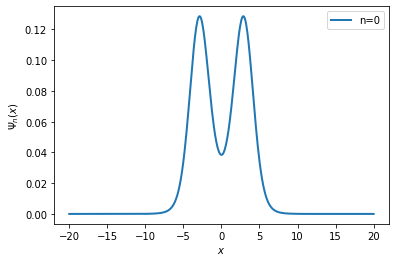

E = 0.3550396372536511


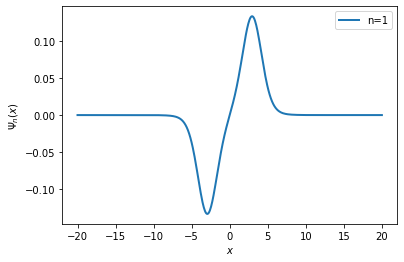

E = 9.393537579794367


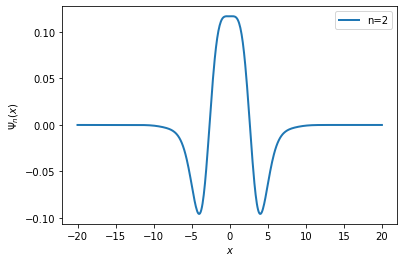

E = 12.325127075462559


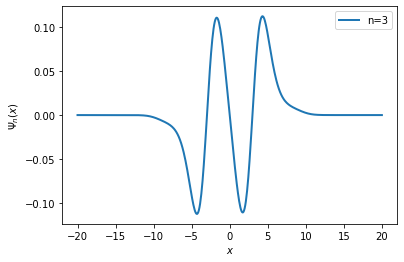

In [126]:
H = buildH(p0,Ec,El,Ej)
w, v = eigh(H)

nlowest = 4
print ('energies:', w[0:nlowest])

E0 = w[0]

import matplotlib.pyplot as plt
#plt.plot(xmesh, [Vpot(x) for x in xmesh], 'k-', lw=2)

for n in range(nlowest):
    print(f"E = {w[n]-w[0]}")
    plt.figure(n)
    plt.plot(xmesh, v[:,n],'-', label='n=%g'%(n), lw=2)
    plt.xlabel('$x$')
    plt.ylabel('$\Psi_{n}(x)$')
    plt.legend()
    plt.show()

One of prominent features of Fluxonium is its large energy gap between computational qubit states and excited states. Due to this feature, we can project the wavefunction and Hamiltonian into the qubit computational subspace.

$$ P = |e\rangle\langle e|+|g\rangle\langle g|$$

And the Hamiltonian would become

$$ P\hat{H} P^T = P \hat{H}_h P^T - E_j[P\cos (\hat{\phi})P^T \cos (2\pi \frac{\phi_{ext}}{\phi_0})+  P\sin(\hat{\phi})P^T \sin (2\pi \frac{\phi_{ext}}{\phi_0})]$$

In this case, to save computational resource, each matrix can be stored precedingly.

In [65]:
P_sub = v[:,0:2]

CosMat = Ej*P_sub.T@jnp.diag(jnp.array([jnp.cos(x) for x in xmesh]))@P_sub
SinMat = Ej*P_sub.T@jnp.diag(jnp.array([jnp.sin(x) for x in xmesh]))@P_sub
H_harm = P_sub.T@(jnp.eye(Nmesh)*(Ec*4./(h*h))- 2*(jnp.eye(Nmesh,k=1)+jnp.eye(Nmesh,k=-1))*Ec/(h*h) # Kinetic energy
                 + jnp.diag(jnp.array([0.5*El*x**2 for x in xmesh])))@P_sub

In [66]:
print(SinMat)
print(H_harm)

[[ 1.00527992e-13  1.46614780e+00]
 [ 1.46614780e+00 -1.59603568e-13]]
[[3.37953423e+00 3.58755184e-14]
 [3.74958875e-14 4.03296522e+00]]


Til now we can try optmize control in this sub system, for example $\sigma_x$ gate

In [140]:
@jit
def A(t,p,t1):
    '''
    Control field phi, use Cosin series
    '''
    w = 2*jnp.pi/t1
    N1, = jnp.shape(p)
    ft = jnp.array([jnp.cos(w*i*t) for i in range(N1)])
    return p@ft+p0


def loss(t1,flat_p,H0,Cosphi,Sinphi,U_T):
    '''
    define the loss function, which is a pure function to speed up
    '''
    t_set = jnp.linspace(0., t1, 5)

    D, _, = jnp.shape(U_T)
    U_0 = jnp.eye(D,dtype=jnp.complex128) # start with Identity matrix
    
    def H_sub(phi):
        return H0-(Cosphi*jnp.cos(2*jnp.pi*phi)+Sinphi*jnp.sin(2*jnp.pi*phi))

    def func(y, t, *args):
        t1,flat_p, = args
        PHI = A(t,flat_p,t1)
        return -1.0j*H_sub(PHI)@y

    res = odeint(func, U_0, t_set, t1, flat_p,
                 rtol=1.4e-10, atol=1.4e-10)
    
    U_F = res[-1, :,:]
#     print(U_F)
    return (1 - jnp.abs(jnp.trace(U_T.conj().T@U_F)/D)**2)

def U_f(t1,flat_p,H0,Cosphi,Sinphi):
    
    t_set = jnp.linspace(0., t1, 5)

    D, _, = jnp.shape(H0)
    U_0 = jnp.eye(D,dtype=jnp.complex128) # start with Identity matrix
    
    def H_sub(phi):
        return H0-(Cosphi*jnp.cos(2*jnp.pi*phi)+Sinphi*jnp.sin(2*jnp.pi*phi))

    def func(y, t, *args):
        t1,flat_p, = args
        PHI = A(t,flat_p,t1)
        return -1.0j*H_sub(PHI)@y

    res = odeint(func, U_0, t_set, t1, flat_p,
                 rtol=1.4e-10, atol=1.4e-10)
    
    U_F = res[-1, :,:]
    return U_F

One way of optimize is with L-BFGS

In [75]:
from scipy.optimize import minimize

def GateOptimize_LBFGS(U_F, t1, H0,Cosphi,Sinphi, init_param,):
    '''
    Implementation with LBFGS
    '''
    loss_list = []
    
    loss_and_grad = jit(jax.value_and_grad(loss,(0,1)))
    
    def fun(p,*args):
        t0, p0 = p[0], p[1:]
        f, (gt,gp) = loss_and_grad(t0,p0,H0,Cosphi,Sinphi,U_F)
        gd = np.concatenate([np.array([gt]),gp])
        loss_list.append(f)
        print(f'loss = {f}')
        return f, gd
    
    results = minimize(fun,np.concatenate([np.array([t1]),init_param]), method='L-BFGS-B', jac=True, 
                       options={'gtol': 1e-07})
    return loss_list,results.x

With ADAM optimizer as well

In [8]:
def GateOptimize_adam(U_F, t1, init_param,H0,Cosphi,Sinphi, num_step=200, learning_rate=1.0):
    '''
    Get the best possible parameter
    psi_i: initial wave function
    psi_f: final wave function
    init_param: initial parameters
    '''
    opt_init, opt_update, get_params = optimizers.adam(
        learning_rate)  # Use adam optimizer
    loss_list = []
    
    import time
    
    def step_fun(step, opt_state, U_F):
        aug_params = get_params(opt_state)
        t1, flat_params = aug_params
        ta = time.time()
        value, grads = jit(jax.value_and_grad(
            loss, (0, 1)))(t1, flat_params, H0,Cosphi,Sinphi, U_F) # use jax autograd
        tb= time.time()
        print(f'value and grad cost {tb-ta} seconds')
        g_t, g_p = grads
        aug_grad = (g_t,g_p)
        opt_state = opt_update(step, aug_grad, opt_state)
        tc= time.time()
        print(f'value and grad cost {tc-tb} seconds')
        return value, opt_state

    aug_params = (t1,init_param)
    opt_state = opt_init(aug_params)

    # optimize
    for step in range(num_step):
        value, opt_state = step_fun(step, opt_state, U_F)
        loss_list.append(value)
        print('step {0} : loss is {1}'.format(
            step, value), end="\r", flush=True)

    print('final loss = ', value, flush=True)
    return loss_list, get_params(opt_state)


And now try the direct gradient descent of loss function

In [9]:
def GradientDecent(t0,p0,num=100,e=1e-6,lr=1e-3):
    loss_list = []
    l = 1.
    for n in range(num):
        l,(gt,gp) = jit(jax.value_and_grad(loss,(0,1)))(t0,p0,H_harm,CosMat,SinMat,sx)
        loss_list.append(l)
        t0 = t0 - lr*gt
        p0 = p0 - lr*gp
        print(f'step {n}, loss = {l}',end='\r',flush = True)
    return loss_list,(t0,p0)

Test the pretested coefficient from mathematica

In [84]:
tf = 1.40829
p_opt = jnp.array([0.242183, 0.22217, 0.167103, 0.0903744, 0.00976605, -0.0577118, \
-0.100383, -0.114443, -0.103836, -0.0778022, -0.0471902, -0.0209454, \
-0.00391343, 0.00351765, 0.00417113, 0.00201775])

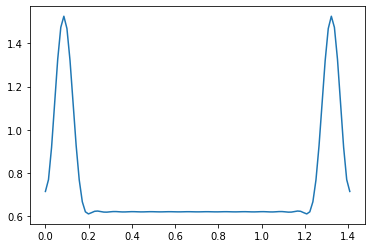

In [85]:
t_list = jnp.linspace(0.,tf,100)
A_list = vmap(A,in_axes=(0,None,None),out_axes=0)(t_list,p_opt,tf)

plt.plot(t_list,A_list)
plt.show()

And we evaluate the loss

In [86]:
loss_preopt = loss(tf,p_opt,H_harm,CosMat,SinMat,sx)

[[ 0.35955173-0.28094194j -0.68682816-0.56573957j]
 [-0.68682816-0.56573957j  0.20686574-0.40670922j]]


In [87]:
print(loss_preopt)

0.2082058214752155


it's already better than our previous result. After this, we can do the LBFGS optimization

In [88]:
loss_list_LBFGS,res = GateOptimize_LBFGS(sx,tf,H_harm,CosMat,SinMat,p_opt)

Traced<ShapedArray(complex128[2,2])>with<JVPTrace(level=2/1)>
  with primal = Traced<ShapedArray(complex128[2,2])>with<DynamicJaxprTrace(level=0/1)>
       tangent = Traced<ShapedArray(complex128[2,2]):JaxprTrace(level=1/1)>
loss = 0.20820582147521555
loss = 0.17656826584093965
loss = 0.9978586568063118
loss = 0.6640682707214268
loss = 0.07910421137250763
loss = 0.057568643861008975
loss = 0.6526595159118874
loss = 0.042838575347694564
loss = 0.3795787178597936
loss = 0.03248844703612244
loss = 0.03604123826921749
loss = 0.027835264141601368
loss = 0.025339235822432683
loss = 0.019069471081126912
loss = 0.015488730952058924
loss = 0.012247524557361174
loss = 0.02073362613495185
loss = 0.011551812479883128
loss = 0.010905896301970404
loss = 0.010098870603479115
loss = 0.009372633446888101
loss = 0.00897610230656711
loss = 0.008407326492032503
loss = 0.007901832858634586
loss = 0.1446513889581624
loss = 0.007629899566823059
loss = 0.01298490684568669
loss = 0.0069063328058071504
loss = 0

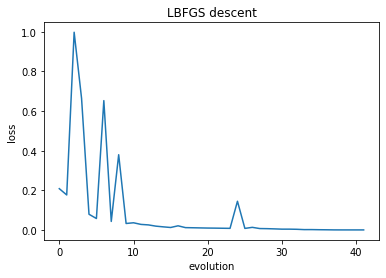

In [89]:
plt.plot([n for n in range(len(loss_list_LBFGS))],loss_list_LBFGS)
plt.title('LBFGS descent')
plt.ylabel('loss')
plt.xlabel('evolution')
plt.show()

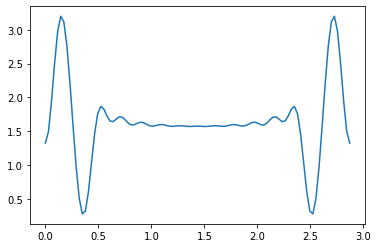

In [90]:
tfinal,pfinal = res[0],res[1:]
t_list = jnp.linspace(0.,tfinal,100)
A_list = vmap(A,in_axes=(0,None,None),out_axes=0)(t_list,pfinal,tfinal)

plt.plot(t_list,A_list)
plt.show()

In [80]:
loss_preopt = loss(tfinal,pfinal,H_harm,CosMat,SinMat,sx)

[[-1.29431697e-06-4.62979323e-07j  2.74406365e-01+9.61613824e-01j]
 [ 2.74406364e-01+9.61613824e-01j -8.55151921e-07+1.07618182e-06j]]


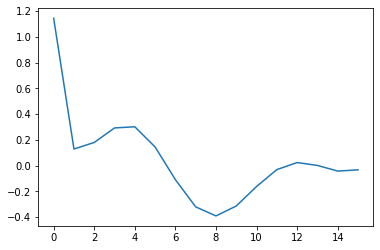

In [92]:
x = range(pfinal.shape[0])
plt.plot(x,pfinal)
plt.show()

We can substract dc component of 1

In [95]:
p_new = pfinal-jnp.array([1]+[0 for _ in range(pfinal.shape[0]-1)])

[[4.89567841e-08+1.26977598e-08j 4.49144993e-01+8.93458883e-01j]
 [4.49144993e-01+8.93458883e-01j 1.90144192e-08-4.68410845e-08j]]
3.2871483313101635e-11


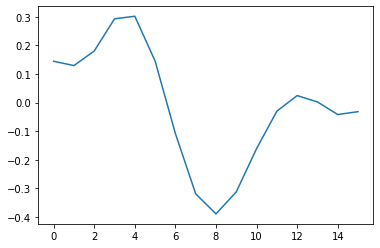

In [99]:
loss_sub = loss(tfinal,p_new,H_harm,CosMat,SinMat,sx)
print(loss_sub)

x = range(p_new.shape[0])
plt.plot(x,p_new)
plt.show()

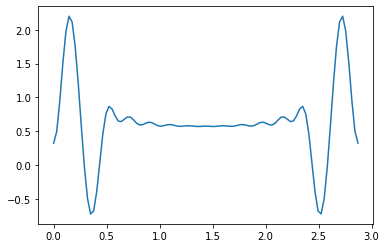

In [100]:
t_list = jnp.linspace(0.,tfinal,100)
A_list = vmap(A,in_axes=(0,None,None),out_axes=0)(t_list,p_new,tfinal)

plt.plot(t_list,A_list)
plt.show()

Like what we previously did, we can calculate the Hessian matrix of the system

In [104]:
from jax import jacrev
loss_p = lambda p: loss(tfinal,p,H_harm,CosMat,SinMat,sx)
Hess = jacrev(jacrev(loss_p))(p_new)
w0, v0 = jnp.linalg.eig(Hess)

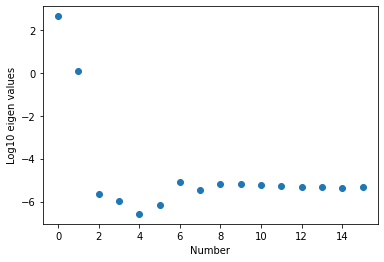

In [105]:
plt.plot(range(len(w0)),np.log10(np.abs(w0)),'o')
plt.xlabel('Number')
plt.ylabel('Log10 eigen values')

plt.show()

There are only two main eigenvalues

In [109]:
arglist = jnp.argsort(w0)[-2:]
main_eigen = w0[arglist]
main_vec = v0[:, arglist]

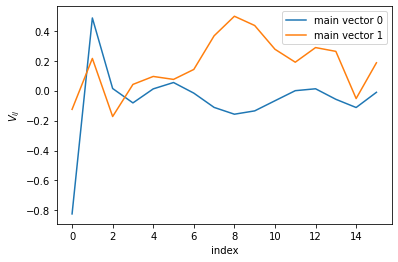

In [110]:
for i in range(p_new.shape[0]):
    if i in arglist:
        plt.plot(range(p_new.shape[0]), v0.real[:,i],label=f"main vector {i}")

plt.xlabel("index")
plt.ylabel("$V_{ij}$")

plt.legend(loc='upper right',bbox_to_anchor=(1, 1))
plt.show()

Now we can test the performance in 

In [127]:
P_sub_four = v[:,0:4]

CosMatfour = Ej*P_sub_four.T@jnp.diag(jnp.array([jnp.cos(x) for x in xmesh]))@P_sub_four
SinMatfour = Ej*P_sub_four.T@jnp.diag(jnp.array([jnp.sin(x) for x in xmesh]))@P_sub_four
H_harmfour = P_sub_four.T@(jnp.eye(Nmesh)*(Ec*4./(h*h))- 2*(jnp.eye(Nmesh,k=1)+jnp.eye(Nmesh,k=-1))*Ec/(h*h) # Kinetic energy
                 + jnp.diag(jnp.array([0.5*El*x**2 for x in xmesh])))@P_sub_four

In [141]:
U_infour = U_f(tfinal,p_new,H_harmfour,CosMatfour,SinMatfour)

In [142]:
print(U_infour)

[[ 0.31446275-0.30392072j -0.15261004-0.49574428j -0.31918156+0.08727422j
   0.65500276+0.03421828j]
 [-0.15261004-0.49574428j  0.304389  +0.65930419j -0.05327537-0.09866816j
   0.39004357+0.19724466j]
 [-0.31918155+0.08727422j -0.05327537-0.09866816j  0.34442119+0.68724098j
   0.15613545+0.51247269j]
 [ 0.65500276+0.03421828j  0.39004357+0.19724466j  0.15613545+0.51247269j
  -0.03490202-0.30089261j]]


In [144]:
Transfer_mat = U_infour[0:2,2:4]
print(Transfer_mat)

[[-0.31918156+0.08727422j  0.65500276+0.03421828j]
 [-0.05327537-0.09866816j  0.39004357+0.19724466j]]


In [146]:
print(jnp.linalg.norm(Transfer_mat))
print(jnp.linalg.norm(U_infour[0:2,0:2]))

0.8621521158503518
1.1210235173158478


Sadly the excitation on the excited state is too strong making our presumption falsify. Because there are strong high frequency component exsisting

In [150]:
16/tfinal

5.5715535485948955